# Artifacts with GPT-4o using Portkey

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-CyvKS3JlhkN-rV88AdZSdg5a5V7stzs?usp=sharing)

<h1 align="center">
  <a href="https://portkey.ai">
    <img width="300" src="https://analyticsindiamag.com/wp-content/uploads/2023/08/Logo-on-white-background.png" alt="portkey">
  </a>
</h1>

In [ ]:
!pip install -qU portkey-ai openai e2b_code_interpreter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.9/405.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Get your API keys or save them to .env file.
import os
from google.colab import userdata

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = userdata.get('E2B_API_KEY')





SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

In [ ]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [ ]:
from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders
from google.colab import userdata
import json

gateway = OpenAI(
    api_key=userdata.get("OPENAI_API_KEY"),
    base_url=PORTKEY_GATEWAY_URL, # Or http://localhost:8787/v1 when running locally
    default_headers=createHeaders(
        provider="openai",
        api_key=userdata.get("PORTKEY_API_KEY") # Grab from https://app.portkey.ai # Not needed when running locally
    )
)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = gateway.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if "code" in tool_call.function.arguments:
            code = tool_call.function.arguments["code"]
          else:
            code = tool_call.function.arguments
          print("CODE TO RUN")
          print(code)
          code_interpreter_results = code_interpret(e2b_code_interpreter, code)
          return code_interpreter_results
    else:
      print("Answer:", choice.message.content)

# Example 1 :- distribution of salaries in the tech industry


User Message: Plot a chart visualizing the height distribution of men based on the data you know
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt

# Set mean and standard deviation
mean_height = 69  # average height in inches
std_dev_height = 3  # standard deviation in inches

# Generate synthetic dataset
np.random.seed(0)
heights = np.random.normal(mean_height, std_dev_height, 1000)  # generate 1000 data points

# Plotting the height distribution
plt.figure(figsize=(10, 6))
plt.hist(heights, bins=30, edgecolor='black', alpha=0.7)
plt.title("Height Distribution of Men")
plt.xlabel("Height (inches)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
Running code interpreter...
[Result(<Figure size 1000x600 with 1 Axes>)]
{'text/plain': '<Figure size 1000x600 with 1 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA0kAAAIjCAYAAADWYVDIAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPY

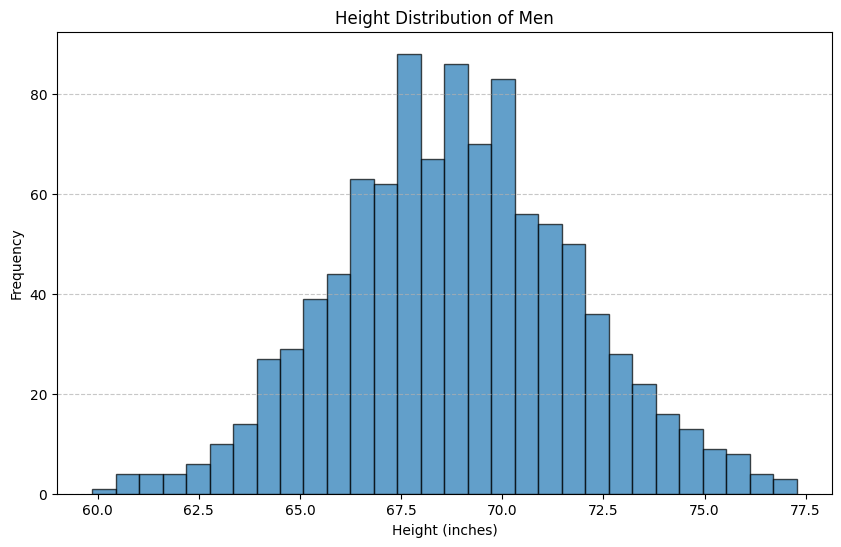

In [ ]:
from e2b_code_interpreter import CodeInterpreter
code_interpreter = CodeInterpreter(api_key=E2B_API_KEY)

# 1. Ask GPT-4o to generate chart
code_interpreter_results = chat(
  code_interpreter,
  "Plot a chart visualizing the height distribution of men based on the data you know",
)
print(code_interpreter_results)
plot1 = code_interpreter_results[0]


print(plot1.raw)
plot1

#Generate a histogram and a box plot to show the distribution of salaries

In [ ]:
# 2. Feed the image back the chart to GPT-4o and ask question about the image
image = plot1.png
code_interpreter_results = chat(
  code_interpreter,
  "Based on what you see, what's name of this distribution? Show me the distribution function",
  image,
)

code_interpreter.close()

print(code_interpreter_results)
plot2 = code_interpreter_results[0]
print(plot2.raw)
plot2